<a href="https://colab.research.google.com/github/Morganblabla/Estadistica/blob/main/U3P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadística Inferencial II Unidad III
# Ingeniería en Gestión Empresarial

Paulina Morgan Jiménez

23150264

# Parte (a)

Seleccionar una marca y obtener los datos:
Puedes utilizar una fuente como Yahoo Finance o una API como Alpha Vantage para obtener los precios de cierre diarios de las acciones durante el último año.


In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = ' DHPC9H7AV1MBJ0PY'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
ticker = 'JPM'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

inicio = '2024-01-01'
fin = '2025-04-01'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Volume
date,,,,,
2025-04-01,242.620,245.690,240.8818,243.66,8054683.0
2025-03-31,239.410,245.860,237.3643,245.30,13602996.0
2025-03-28,246.940,249.505,241.1100,242.85,11978417.0
2025-03-27,249.525,250.640,247.1800,248.12,8022517.0
2025-03-26,252.600,254.670,249.7800,251.03,12785225.0
...,...,...,...,...,...
2024-01-08,172.020,172.360,169.4850,172.02,11229916.0
2024-01-05,171.470,173.380,171.4700,172.27,10038385.0
2024-01-04,170.640,173.350,170.5400,171.41,11972545.0


Graficar la serie de tiempo:
Una vez que tengas los datos, utiliza una biblioteca como matplotlib en Python para graficarlos.
Asegúrate de etiquetar el eje x como "Fecha" y el eje y como "Precio de cierre". Si es necesario, incluye una leyenda con el nombre de la marca.

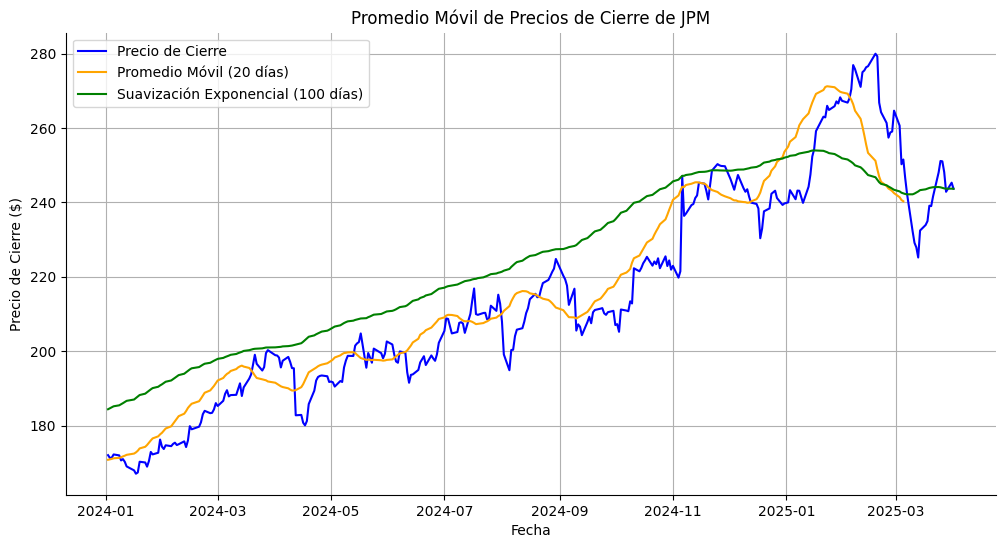

In [ ]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['JPM_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['JPM_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de JPM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusión Parte (a):**

El precio de cierre de las acciones de JP Morgan ha mostrado una tendencia ascendente general, con fluctuaciones a corto plazo que se suavizan con el promedio móvil de 20 días y la suavización exponencial de 100 días, sugiriendo estabilidad y crecimiento, aunque con cierta volatilidad.


# Parte (b)
Prueba de estacionariedad:

Utiliza una prueba como la prueba de raíz unitaria de Dickey-Fuller aumentada (ADF) o KPSS para determinar si la serie es estacionaria.
Los resultados de la prueba te indicarán si rechazas o no la hipótesis nula de no estacionariedad, lo cual puedes interpretar para concluir si la serie es estacionaria.

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller


nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['JPM_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -0.7292155593922487
p-value: 0.839036238127933
La tendencia no es estacionaria (aceptamos la hipótesis nula).


**Conclusión Parte b:**

La prueba de Dickey-Fuller aumentada indica que la serie no es estacionaria, ya que el p-valor es alto (0.839), lo que lleva a aceptar la hipótesis nula de no estacionariedad.


# Parte (c)

Regresión polinomial:

Realiza una regresión polinomial de diferentes grados sobre los datos para identificar el grado mínimo necesario que logre que los residuales sean estacionarios.
Puedes usar numpy o sklearn para la regresión polinomial y luego obtener los residuales.

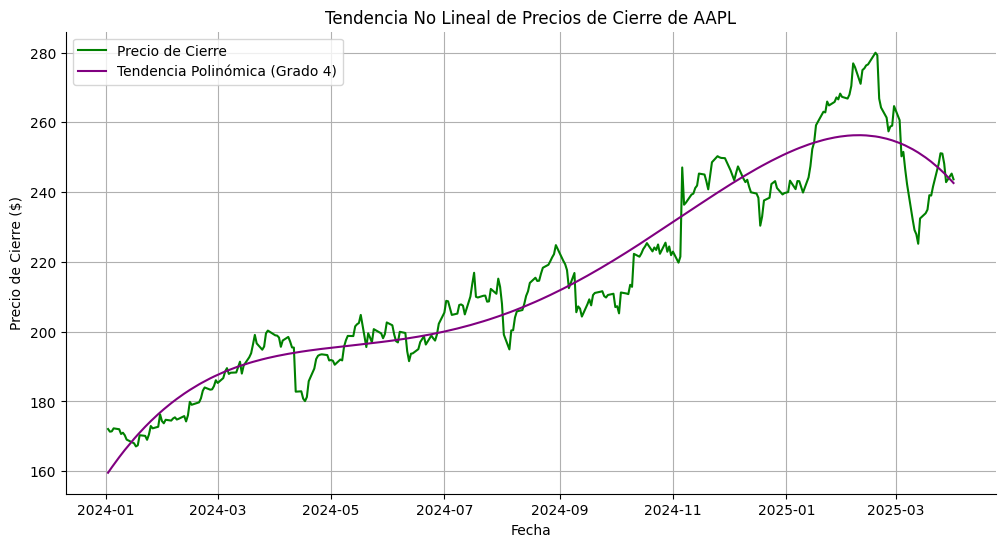

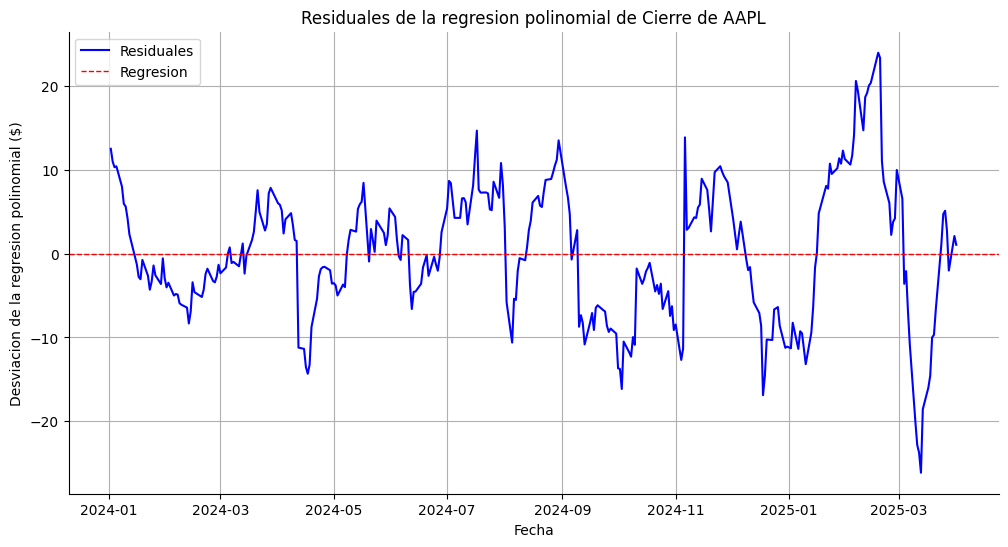

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['JPM_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 4
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusión regresión polinomial:**

La regresión polinomial de grado 4 reduce significativamente la no estacionariedad en los residuales, mostrando una tendencia más estable alrededor de cero, lo que sugiere que el modelo es adecuado para capturar la tendencia subyacente de la serie.


Prueba de estacionariedad en los residuales:

Aplica una prueba de estacionariedad (como ADF) en los residuales para verificar si se ha logrado la estacionariedad.

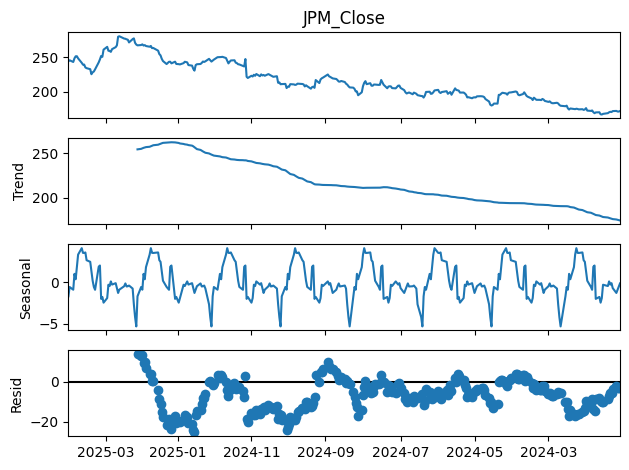

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['JPM_Close'],
    model='additive',
    period=40,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(descomposicion.resid.dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -3.514644629066398
p-value: 0.007618858656275204
La tendencia es estacionaria (rechazamos la hipótesis nula).


**Conclusión prueba de estacionalidad en residuales:**

La prueba de Dickey-Fuller aumentada (ADF) aplicada a los residuales muestra un valor del estadístico ADF de -3.5146 y un p-valor de 0.0076. Debido a que el p-valor es menor que 0.05, se rechaza la hipótesis nula de no estacionariedad, lo que indica que los residuales son estacionarios. Esto confirma que la regresión polinomial utilizada ha logrado capturar correctamente la tendencia, haciendo que la serie sea más estable para análisis y pronósticos futuros.